In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

bits_minuto = 90
pulses_number = 90
distance = 0.6

In [15]:
df = pd.DataFrame()

sensor1=np.loadtxt("../data/sensor_data1.txt", delimiter=",")
sensor2=np.loadtxt("../data/sensor_data2.txt", delimiter=",")

if len(sensor1) >= len(sensor2):
    df["sensor2"] = np.loadtxt("../data/sensor_data2.txt", delimiter=",")
    df["sensor1"] = np.loadtxt("../data/sensor_data1.txt", delimiter=",")[:len(sensor2)]
else:
    df["sensor1"] = np.loadtxt("../data/sensor_data1.txt", delimiter=",")
    df["sensor2"] = np.loadtxt("../data/sensor_data2.txt", delimiter=",")[:len(sensor1)]
    

In [16]:
#rull out noise
df = df[8000:]
df = df[:-8000]


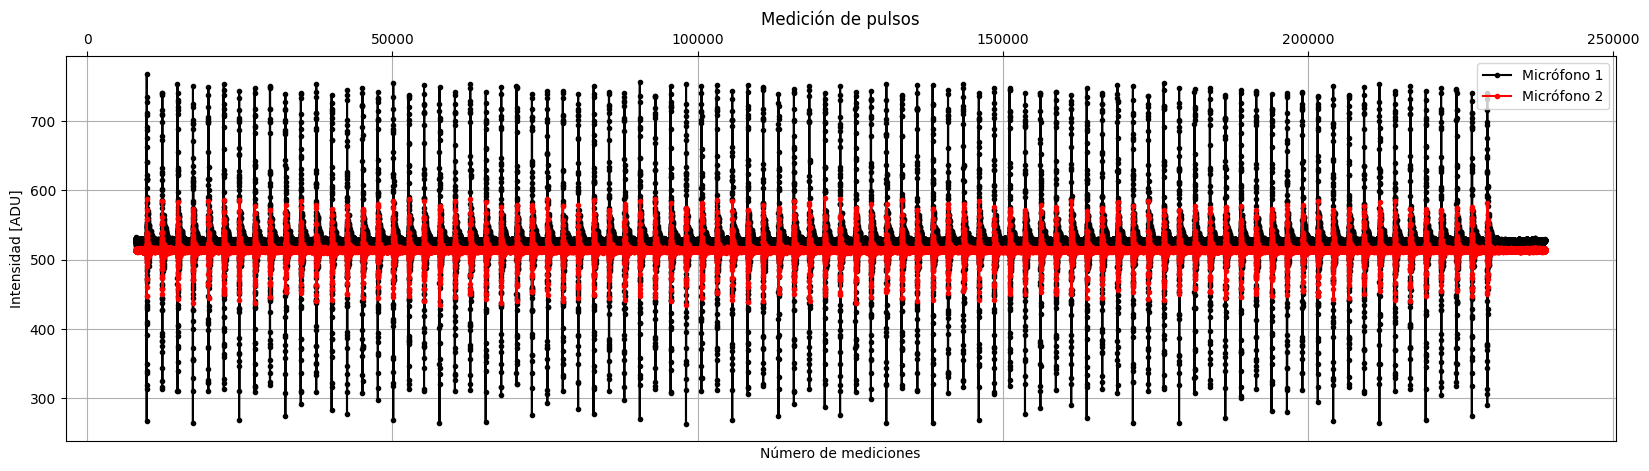

In [17]:
ax = plt.gca()
ax.xaxis.tick_top()
ax.plot(df.index, df["sensor1"], "k.-", label = "Micrófono 1")
ax.plot(df.index, df["sensor2"], "r.-", label = "Micrófono 2")
ax.grid()
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.title("Medición de pulsos")
#x lim
plt.xlabel("Número de mediciones")
plt.ylabel("Intensidad [ADU]")
plt.legend()
# a=20000
# b=25000
#plt.xlim(24300,24800)

In [18]:
df = df.reset_index().rename(columns={"index": "time"})

In [19]:
#identify as many sensors as pulses_number
kmeans_sensor1 = KMeans(n_clusters=pulses_number, random_state=0).fit(df[["time", "sensor1"]])
kmeans_sensor2 = KMeans(n_clusters=pulses_number, random_state=0).fit(df[["time", "sensor2"]])

#write the clasification for each row in df_sensor1 and df_sensor2
df["sensor1_pulse"]=kmeans_sensor1.labels_
df["sensor2_pulse"]=kmeans_sensor2.labels_

/home/sant/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


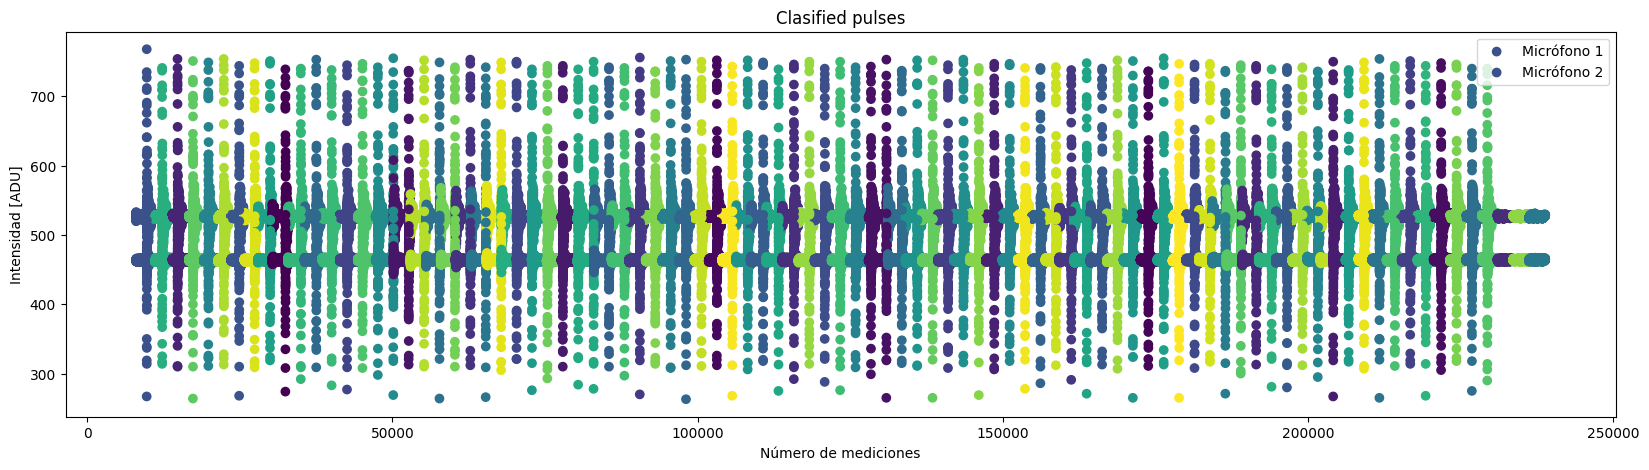

In [20]:
#plot the clasification
plt.figure(figsize=(20, 5))
plt.title("Clasified pulses")
plt.scatter(df["time"], df["sensor1"], c=df["sensor1_pulse"], label="Micrófono 1")
plt.scatter(df["time"], df["sensor2"] - 50, c=df["sensor2_pulse"], label="Micrófono 2")
plt.legend()
plt.xlabel("Número de mediciones")
plt.ylabel("Intensidad [ADU]")
#plt.xlim(24500,25500)

plt.show()


In [21]:
#identify the time of the peak for each group
peaks1 = df[["sensor1", "sensor1_pulse"]].groupby("sensor1_pulse").idxmax().reset_index().rename(columns={"sensor1_pulse": "pulse"})

for pulse in peaks1["pulse"]:
    pulse_df = df.query(f"sensor1_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor1"].max()) < pulse_df["sensor1"].mean() + 5*pulse_df["sensor1"].std():
        peaks1 = peaks1.query(f"pulse != {pulse}")

peaks2 = df[["sensor2", "sensor2_pulse"]].groupby("sensor2_pulse").idxmax().reset_index().rename(columns={"sensor2_pulse": "pulse"})

for pulse in peaks2["pulse"]:
    pulse_df = df.query(f"sensor2_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor2"].max()) < pulse_df["sensor2"].mean() + 5*pulse_df["sensor2"].std():
        peaks2 = peaks2.query(f"pulse != {pulse}")


In [22]:
peaks = pd.merge(peaks1, peaks2, on="pulse")

In [23]:
peaks

,pulse,sensor1,sensor2
0,0,24460,24478
1,1,165839,165874
2,2,95145,95176
3,3,213818,213839
4,4,122926,122949
...,...,...,...
81,85,59812,59835
82,86,201182,201215
83,87,145645,145666
84,88,97679,97704


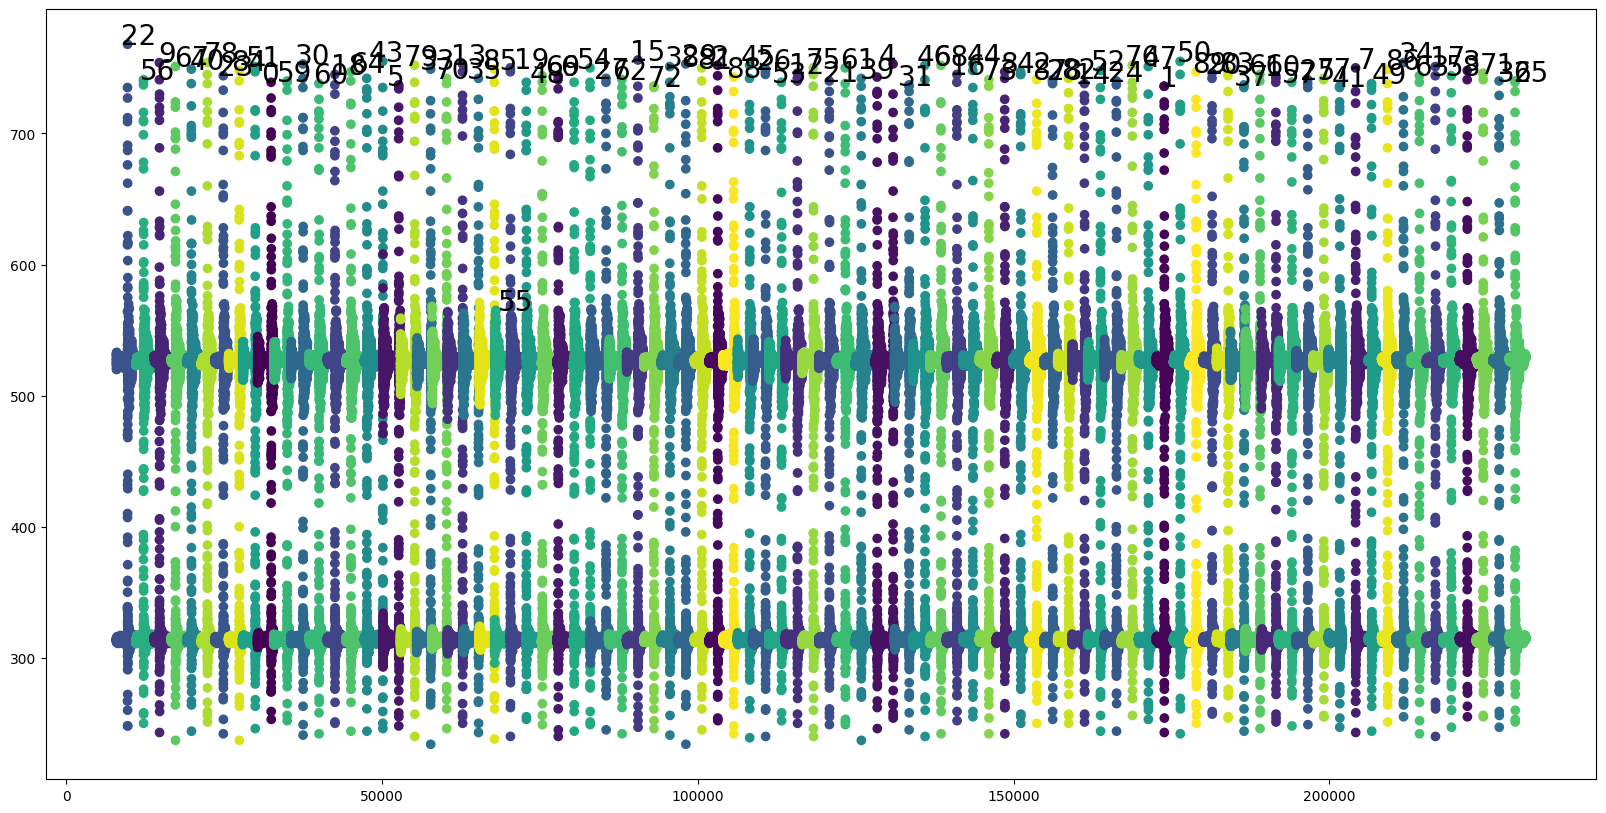

In [24]:
#plot the clasification
df_filtered = df.query("sensor1_pulse in @peaks.pulse and sensor2_pulse in @peaks.pulse")
plt.figure(figsize=(20, 10))
plt.scatter(df_filtered["time"], df_filtered["sensor1"], c=df_filtered["sensor1_pulse"])
plt.scatter(df_filtered["time"], df_filtered["sensor2"] - 200, c=df_filtered["sensor2_pulse"])

#put text over each pulse at the top of the pulse
for peak in peaks["pulse"]:
    peak_df = df_filtered.query(f"sensor1_pulse == {peak}")
    plt.text(peak_df["time"].mean()-peak_df["time"].std(), peak_df["sensor1"].max(), f"{peak}", fontsize=20)
#plt.xlim(4000, 5000)
plt.show()

In [25]:
df_filtered = df_filtered[["time", "sensor1", "sensor2"]]

In [26]:
df_filtered

,time,sensor1,sensor2
0,8000,524.0,513.0
1,8001,528.0,513.0
2,8002,531.0,515.0
3,8003,525.0,513.0
4,8004,524.0,513.0
...,...,...,...
223061,231061,529.0,515.0
223062,231062,529.0,515.0
223063,231063,530.0,514.0
223064,231064,529.0,515.0


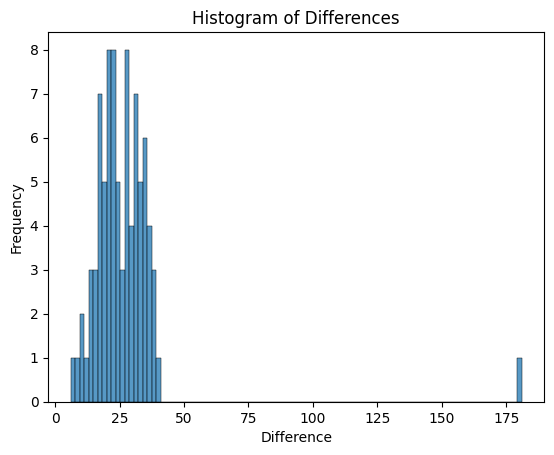

In [28]:
diffs_hist = abs(peaks["sensor1"] - peaks["sensor2"])

# Creating the histogram with Seaborn
sns.histplot(diffs_hist, bins=100)

# Adding title and labels
plt.title('Histogram of Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

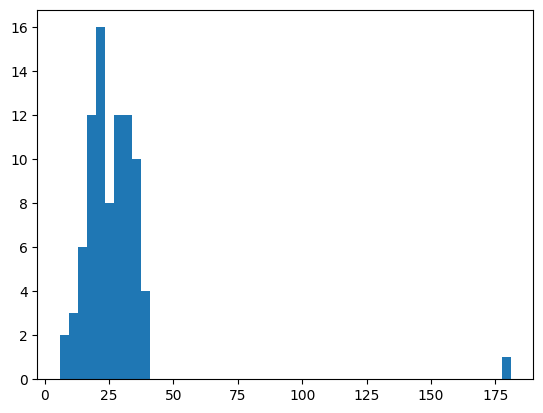

In [30]:
plt.hist(diffs_hist[diffs_hist < 500], bins=50)
plt.show()

In [31]:
gap = int(diffs_hist[diffs_hist<50].mean())

In [32]:
time = gap*3/11369
speed = distance/time
pulses_number, speed, gap

(90, 90.952, 25)